In [29]:
import os
import shutil
import time

from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import train_config_cvppp  # for CVPPP
from criterions.my_loss_cvppp import SpatialEmbLoss  # for CVPPP
from datasets import get_dataset
from models import get_model
from utils.utils_cvppp import AverageMeter, Cluster, Logger, Visualizer  # for CVPPP

torch.backends.cudnn.benchmark = True

args = train_config_cvppp.get_args()

device = torch.device("cuda:0" if args['cuda'] else "cpu")

In [33]:
# train dataloader
train_dataset = get_dataset(
    args['train_dataset']['name'], args['train_dataset']['kwargs'])
train_dataset_it = torch.utils.data.DataLoader(
    train_dataset, batch_size=args['train_dataset']['batch_size'], shuffle=False, drop_last=True,
    num_workers=args['train_dataset']['workers'], pin_memory=True if args['cuda'] else False)

# image files:  100
# label files:  100
CVPPP Dataset created [train]


In [34]:
for i, sample in enumerate(tqdm(train_dataset_it)):

    im = sample['image']
    instances = sample['instance'].squeeze()
    class_labels = sample['label'].squeeze()
    
    if i == 0:
        break
        
print('image :', sample['image'].shape, type(sample['image']))
print('instance :', sample['instance'].shape, type(sample['instance']))
print('label :', sample['label'].shape, type(sample['label']))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

image : torch.Size([5, 3, 512, 512]) <class 'torch.Tensor'>
instance : torch.Size([5, 1, 512, 512]) <class 'torch.Tensor'>
label : torch.Size([5, 1, 512, 512]) <class 'torch.Tensor'>


## Input and GTs

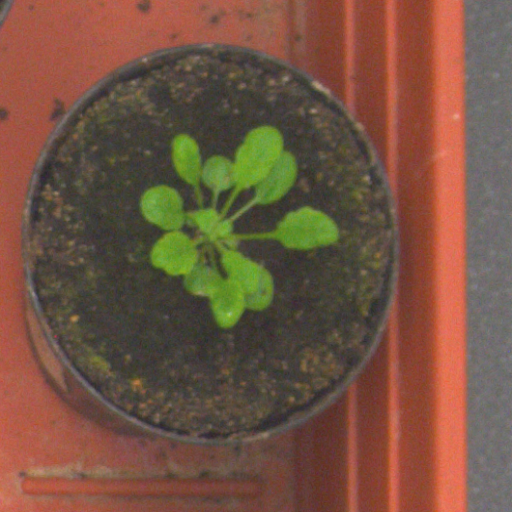

In [35]:
from PIL import Image
import torchvision.transforms as T

transform = T.ToPILImage()
img = transform(im[0])

img

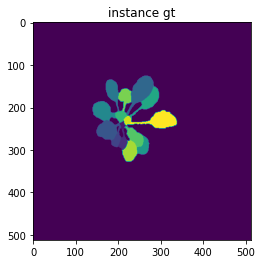

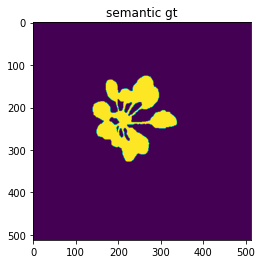

In [36]:
plt.imshow(instances[0].cpu().detach().numpy())
plt.title('instance gt')
plt.show()
plt.imshow(class_labels[0].cpu().detach().numpy())
plt.title('semantic gt')
plt.show()

## Define Model

In [37]:
# set model
model = get_model(args['model']['name'], args['model']['kwargs'])
model.init_output(args['loss_opts']['n_sigma'])
model = torch.nn.DataParallel(model).to(device)

state = torch.load('C:/Users/Moon/Desktop/SpatialEmbedding/src/exp/10/best_iou_model.pth')
model.load_state_dict(state['model_state_dict'], strict=True)
model.eval()

Creating branched erfnet with [3, 1] classes
initialize last layer with size:  torch.Size([16, 3, 2, 2])


DataParallel(
  (module): BranchedERFNet(
    (encoder): Encoder(
      (initial_block): DownsamplerBlock(
        (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layers): ModuleList(
        (0): DownsamplerBlock(
          (conv): Conv2d(16, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): non_bottleneck_1d(
          (conv3x1_1): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
          (conv1x3_1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
          (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=Tr

## Get Prediction

In [38]:
output = model(im) 
print(output.shape)

torch.Size([5, 4, 512, 512])


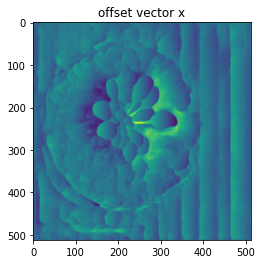

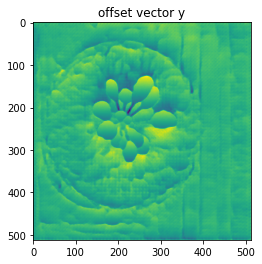

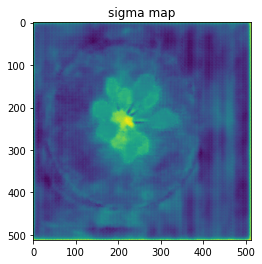

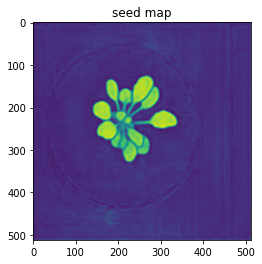

In [39]:
i = 0

plt.imshow(output[i][0].cpu().detach().numpy())
plt.title('offset vector x')
plt.show()
plt.imshow(output[i][1].cpu().detach().numpy())
plt.title('offset vector y')
plt.show()
plt.imshow(output[i][2].cpu().detach().numpy())
plt.title('sigma map')
plt.show()
plt.imshow(output[i][3].cpu().detach().numpy())
plt.title('seed map')
plt.show()

## Calculate Instance Loss (Lovasz Hinge)

### 1. Calculate Spatial Embedding

In [40]:
prediction = output
print(prediction.shape)

batch_size, height, width = prediction.size(
            0), prediction.size(2), prediction.size(3)

torch.Size([5, 4, 512, 512])


In [41]:
 # pixel coordinate map for 512x512
xm = torch.linspace(0, 1, 512).view(
    1, 1, -1).expand(1, 512, 512)  # x-coordinates are within [0, 2] : (1, h, w)
ym = torch.linspace(0, 1, 512).view(
    1, -1, 1).expand(1, 512, 512)  # y-coordinates are within [0, 1] : (1, h, w)
xym = torch.cat((xm, ym), 0)

xym_s = xym[:, 0:height, 0:width].contiguous()

b = 0
spatial_emb = torch.tanh(prediction[b, 0:2]) + xym_s.cuda()

print(spatial_emb.shape)

torch.Size([2, 512, 512])


In [79]:
ym

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9980, 0.9980, 0.9980,  ..., 0.9980, 0.9980, 0.9980],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])

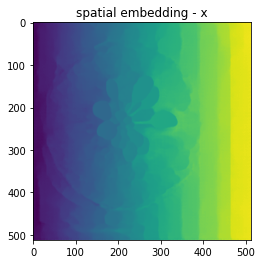

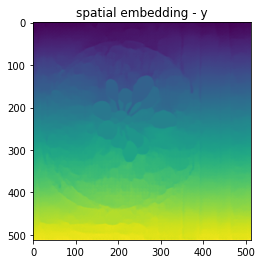

In [42]:
plt.imshow(spatial_emb[0].cpu().detach().numpy())
plt.title('spatial embedding - x')
plt.show()
plt.imshow(spatial_emb[1].cpu().detach().numpy())
plt.title('spatial embedding - y')
plt.show()

### 2. Sigma for instance specific margin

In [43]:
n_sigma = 1
sigma = prediction[b, 2:2 + n_sigma]
print(sigma.shape)

torch.Size([1, 512, 512])


In [44]:
seed_map = torch.sigmoid(
                prediction[b, 2 + n_sigma:2 + n_sigma + 1])  # (1, h, w)
print(seed_map.shape)

torch.Size([1, 512, 512])


### 3. Sigmoid for Seed map

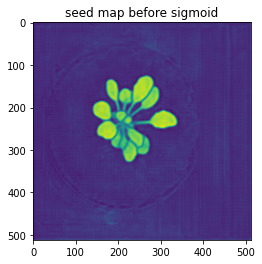

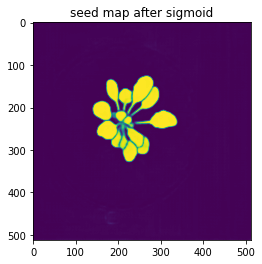

In [45]:
plt.imshow(output[i][3].cpu().detach().numpy())
plt.title('seed map before sigmoid')
plt.show()
plt.imshow(seed_map[0].cpu().detach().numpy())
plt.title('seed map after sigmoid')
plt.show()

### 4. Calculate Score map for each instance (distance map)

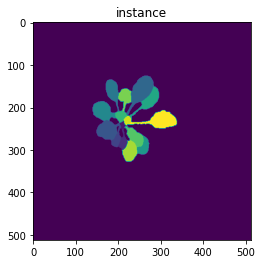

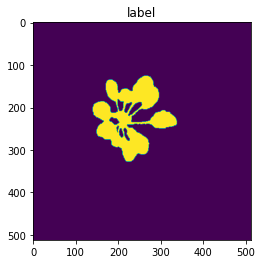

In [46]:
instance = instances[b].unsqueeze(0)  # (1, h, w)
label = class_labels[b].unsqueeze(0)  # (1, h, w)

plt.imshow(instance[0].cpu().detach().numpy())
plt.title('instance')
plt.show()
plt.imshow(label[0].cpu().detach().numpy())
plt.title('label')
plt.show()

In [47]:
# instance lists except bg
instance_ids = instance.unique()
instance_ids = instance_ids[instance_ids != 0]

print('instance lists :', instance_ids)
print('total # of instances :', len(instance_ids))

instance lists : tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=torch.uint8)
total # of instances : 15


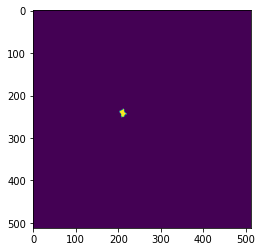

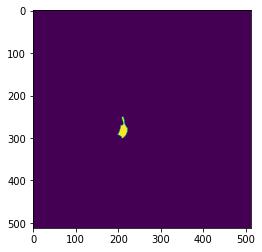

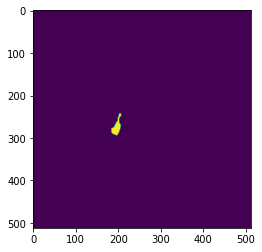

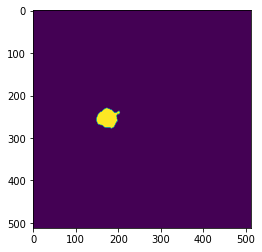

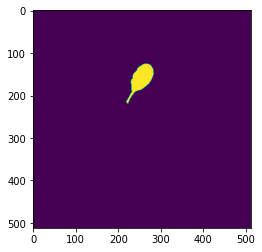

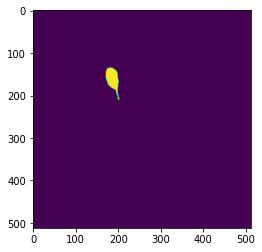

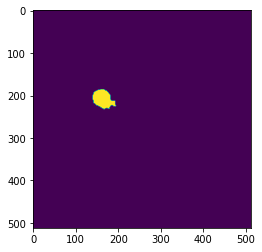

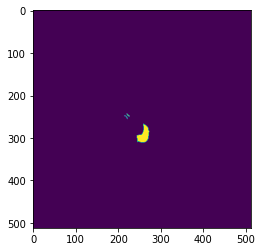

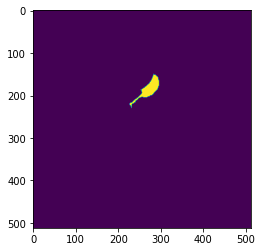

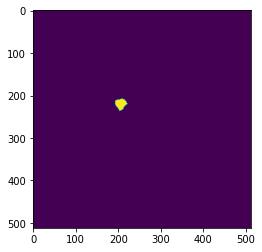

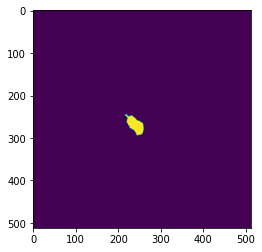

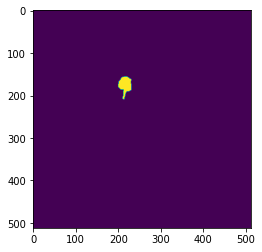

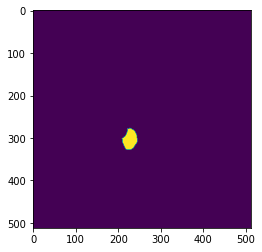

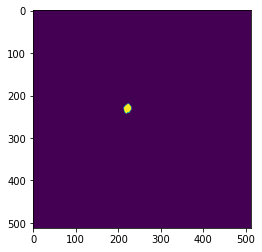

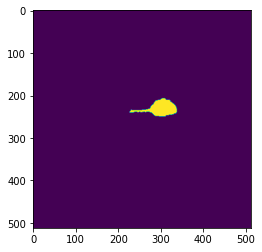

In [74]:
from criterions.lovasz_losses import lovasz_hinge

to_center = True  #
instance_loss = 0
dists = []

# for each instance
for id in instance_ids:

    # mask of specific instance k (RoI k)
    # spatial_emb, sigma, seed_map below only consider the pixels of RoI k
    in_mask = instance.eq(id)  # (1, h, w)
    plt.imshow(in_mask[0].cpu().detach().numpy())
    plt.show()

    # calculate center of attraction
    # if to_center=True -> mean of x, y coordinate maps which belong to instance pixels
    if to_center:
        xy_in = xym_s[in_mask.expand_as(xym_s)].view(2, -1)
        center = xy_in.mean(1).view(2, 1, 1).cuda()  # 2 x 1 x 1

    # defining center as the mean over the pixel-embeddings of instance k
    else:
        center = spatial_emb[in_mask.expand_as(spatial_emb)].view(
            2, -1).mean(1).view(2, 1, 1)  # 2 x 1 x 1

    # calculate sigma belonging to specific instance
    sigma_in = sigma[in_mask.expand_as(
        sigma)].view(n_sigma, -1)

    # sigma_k = avg of all sigma_i belongs to instance k
    s = sigma_in.mean(1).view(
        n_sigma, 1, 1)  # n_sigma x 1 x 1

    # calculate var loss before exp - e.q (5)
    #var_loss = var_loss + \
    #            torch.mean(
    #                torch.pow(sigma_in - s[..., 0].detach(), 2))

    s = torch.exp(s * 10)  # https://github.com/davyneven/SpatialEmbeddings/issues/4

    # calculate gaussian
    # it outputs a fg/bg probability map
    # high value near the instance center, low value at the boundary area
    dist = torch.exp(-1 * torch.sum(
        torch.pow(spatial_emb - center, 2) * s, 0, keepdim=True))  # (1, h, w), 1 for specific instance k
    dists.append(dist)
    
    instance_loss = instance_loss + \
                    lovasz_hinge(dist * 2 - 1, (in_mask * 1).cuda())  # to maximize iou

In [75]:
print(instance_loss)  # s10

tensor(5.0661, device='cuda:0', grad_fn=<AddBackward0>)


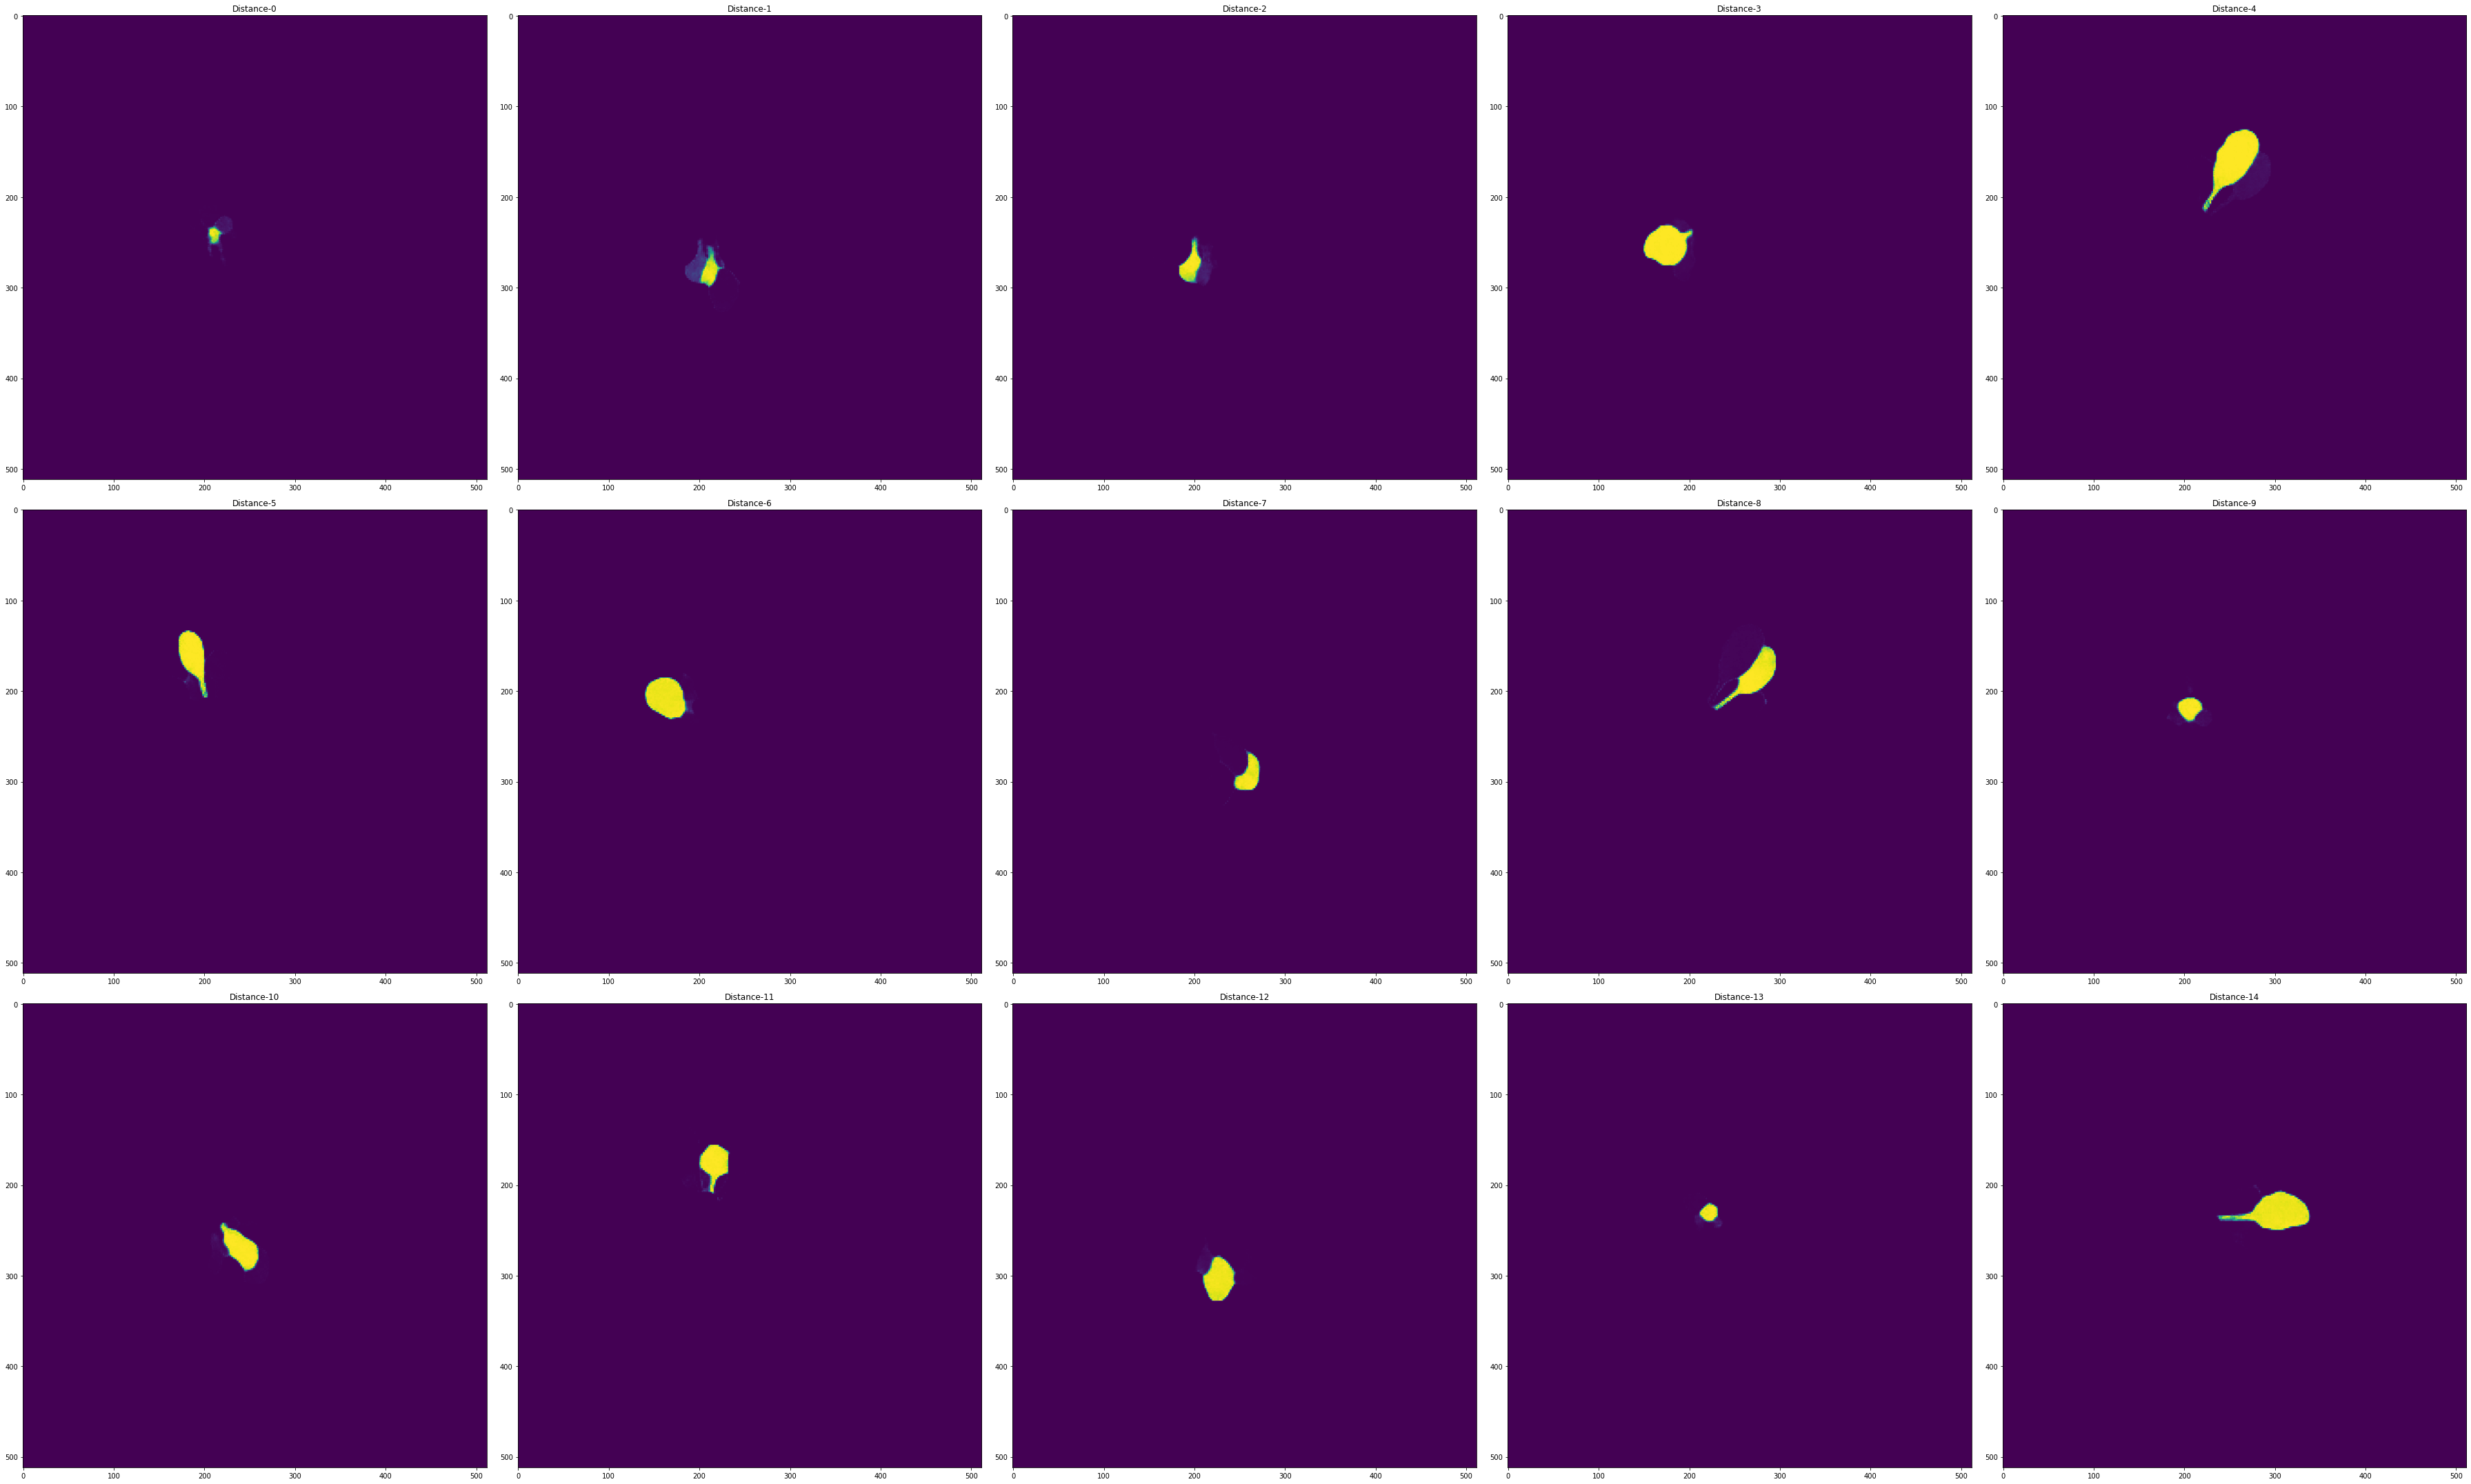

In [76]:
rows = 3
cols = 5
axes = []
fig = plt.figure(figsize=(50, 30))

for a in range(rows * cols):
    b = dists[a][0].cpu().detach()
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title = ("Distance-" + str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    
fig.tight_layout()    
plt.show()

## Post-processing

In [104]:
prediction = output[0]

n_sigma = 1
threshold = 0.9

height, width = prediction.size(1), prediction.size(2)

xm = torch.linspace(0, 1, 512).view(1, 1, -1).expand(1, 512, 512)
ym = torch.linspace(0, 1, 512).view(1, -1, 1).expand(1, 512, 512)
xym = torch.cat((xm, ym), 0)

xym = xym.cuda()

xym_s = xym[:, 0:height, 0:width]

spatial_emb = torch.tanh(prediction[0:2]) + xym_s  # 2 x h x w
sigma = prediction[2:2 + n_sigma]  # n_sigma x h x w

# sigmoid is applied to seed_map
# as the regression loss is used for training, b.g pixels become zero
# it is similar to semantic mask
seed_map = torch.sigmoid(prediction[2 + n_sigma:2 + n_sigma + 1])  # 1 x h x w

instance_map = torch.zeros(height, width).byte()
instances = []

count = 1

# RoI pixels - set of pixels belonging to instances
mask = seed_map > 0.5  # (1, h, w)

if mask.sum() > 128:

    # only consider the pixels which belong to mask (RoI pixels)
    spatial_emb_masked = spatial_emb[mask.expand_as(spatial_emb)].view(2, -1)
    sigma_masked = sigma[mask.expand_as(sigma)].view(n_sigma, -1)
    seed_map_masked = seed_map[mask].view(1, -1)

    unclustered = torch.ones(mask.sum()).byte().cuda()
    instance_map_masked = torch.zeros(mask.sum()).byte().cuda()

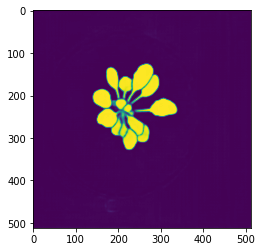

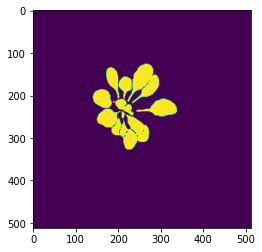

In [114]:
plt.imshow(seed_map.cpu().detach().numpy()[0])  # seed_map
plt.show()
plt.imshow((mask*1).cpu().detach().numpy()[0])  # seed_map > 0.5
plt.show()

# non-zero pixels(yellow area) are roi pixels which belong to semantic-mask area

In [105]:
while (unclustered.sum() > 128):
    # at inference time, we select a pixel embedding with a high seed score
    # embedding with the highest seed score is close to instance's center
    seed = (seed_map_masked * unclustered.float()).argmax().item()
    seed_score = (seed_map_masked * unclustered.float()).max().item()
    if seed_score < threshold:
        break

    # define instance center (embedding with the highest seed score)
    center = spatial_emb_masked[:, seed:seed + 1]
    unclustered[seed] = 0
    # accompanying sigma (instance specific margin)
    s = torch.exp(sigma_masked[:, seed:seed + 1] * 10)
    dist = torch.exp(-1 * torch.sum(torch.pow(spatial_emb_masked -
                                                          center, 2) * s, 0, keepdim=True))

    # e.q (11)
    proposal = (dist > 0.5).squeeze()

    # mask out all clustered pixels in the seed map, until all seeds are masked
    if proposal.sum() > 128:
        if unclustered[proposal].sum().float() / proposal.sum().float() > 0.5:
            instance_map_masked[proposal.squeeze()] = count
            instance_mask = torch.zeros(height, width).byte()
            instance_mask[mask.squeeze().cpu()] = proposal.cpu().byte()
            instances.append(
                {'mask': instance_mask.squeeze() * 255, 'score': seed_score})
            count += 1

    unclustered[proposal] = 0

instance_map[mask.squeeze().cpu()] = instance_map_masked.cpu()

In [83]:
# only consider the pixels which belong to mask (RoI pixels)
spatial_emb_masked = spatial_emb[mask.expand_as(spatial_emb)].view(2, -1)
sigma_masked = sigma[mask.expand_as(sigma)].view(n_sigma, -1)
seed_map_masked = seed_map[mask].view(1, -1)

unclustered = torch.ones(mask.sum()).byte().cuda()
instance_map_masked = torch.zeros(mask.sum()).byte().cuda()

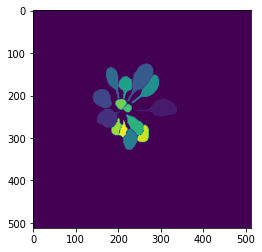

In [106]:
plt.imshow(instance_map.cpu().detach().numpy())  # all instances are clustered
plt.show()

In [107]:
print(instances)  # all of clustered instances were added

[{'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8), 'score': 0.9992973804473877}, {'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8), 'score': 0.9988868832588196}, {'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8), 'score': 0.9988635778427124}, {'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0

In [109]:
print(len(instances))  # # of clustered instances

14


IndexError: list index out of range

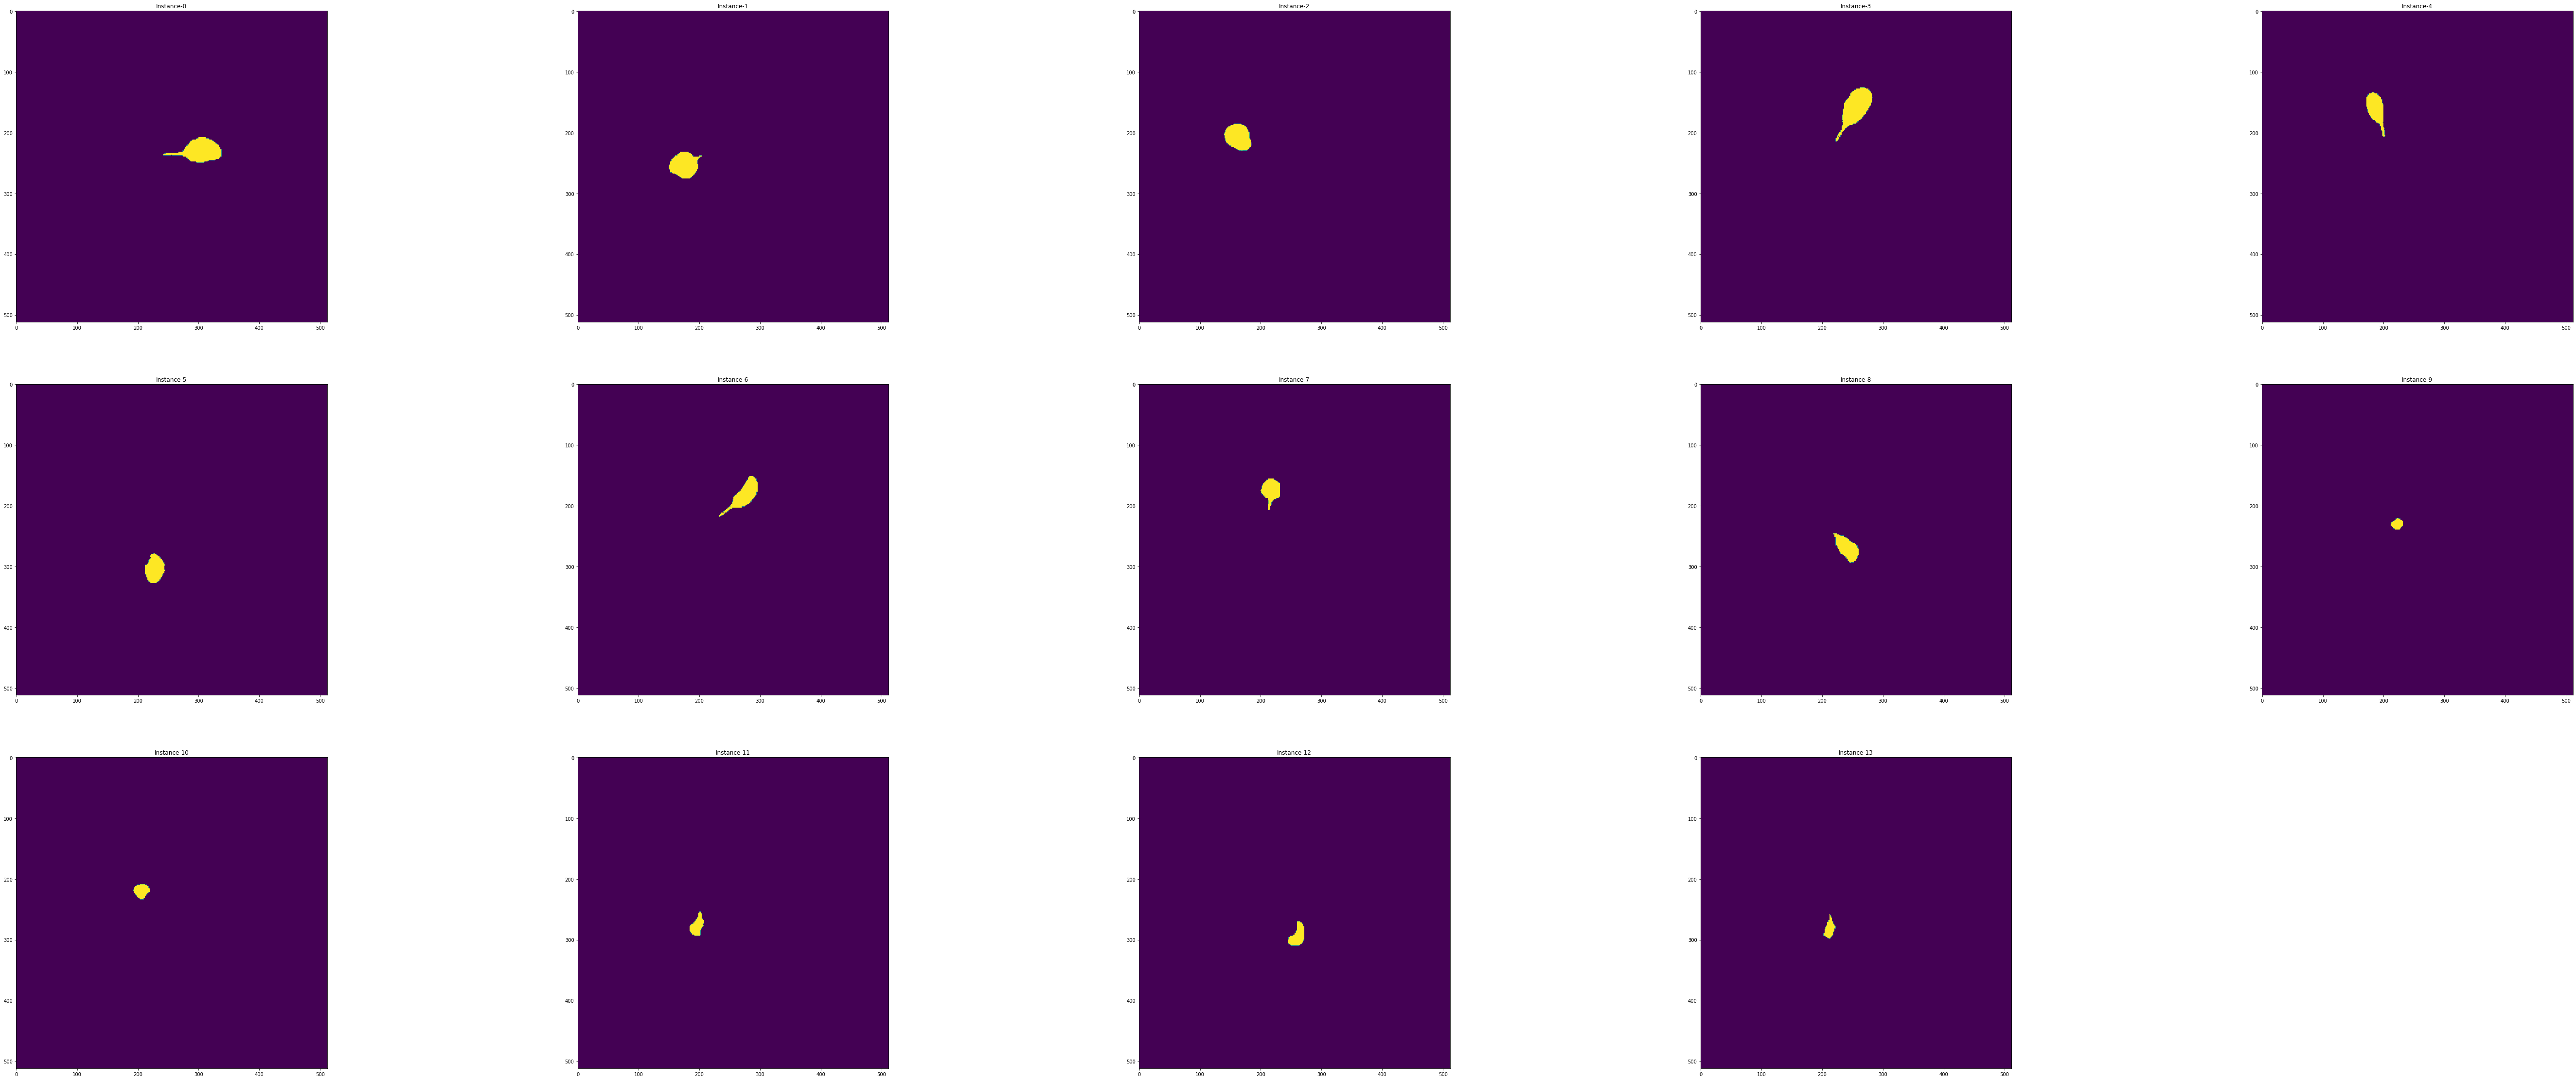

In [110]:
rows = 3
cols = 5
axes = []
fig = plt.figure(figsize=(100, 40))

for a in range(rows * cols):
    b = instances[a]['mask'].cpu().detach()
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title = ("Instance-" + str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    
fig.tight_layout()    
plt.show()

In [112]:
import numpy as np

_n_clusters = len(np.unique(instance_map.flatten())) - 1  # discard bg
print(_n_clusters)

14


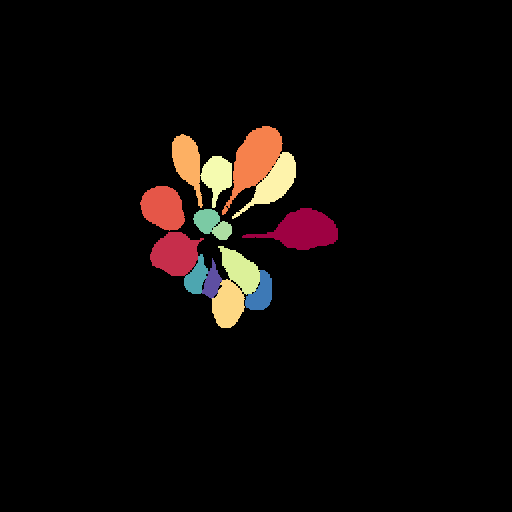

In [113]:
from PIL import Image

_n_clusters = len(np.unique(instance_map.flatten())) - 1  # discard bg
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, _n_clusters)]
ins_seg_pred_color = np.zeros(
        (instance_map.shape[0], instance_map.shape[1], 3), dtype=np.uint8)
for i in range(_n_clusters):
    ins_seg_pred_color[instance_map == (
        i + 1)] = (np.array(colors[i][:3]) * 255).astype('int')
    
ins_seg_pred_color_pil = Image.fromarray(ins_seg_pred_color)
ins_seg_pred_color_pil